## TF reporter activity analysis


### Figure 4 - Reviewing TF specificity by characterizing reporter activities across cell types and upoun TF perturbations

---
Load libraries

In [2]:
# Load libraries:
import matplotlib.pyplot as plt  # Equivalent to RColorBrewer and ggplot2
import pandas as pd  # Equivalent to dplyr, tibble, and readr
pd.set_option('display.max_columns', None)  # Show all columns
import seaborn as sns  # Equivalent to pheatmap and ggpubr
import plotly  # Equivalent to plotly
import numpy as np  # Equivalent to maditr
import string  # Equivalent to stringr
import re  # Equivalent to stringr
import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_3604367/808305366.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd  # Equivalent to dplyr, tibble, and readr


---
**Load data**

In [33]:
# Import RNA-seq correlation data
rna_correlations_df = pd.read_csv('/DATA/usr/m.trauernicht/projects/SuRE-TF/data/rna_correlations_df.tsv', sep='\t')
cDNA_df3 = pd.read_csv('/DATA/usr/m.trauernicht/projects/SuRE-TF/data/rna_correlations_df_all.tsv', sep='\t')

# Import perturbation fold-changes of reporters
on_target_activities = pd.read_csv("/DATA/usr/m.trauernicht/projects/SuRE-TF/data/on_target_activities.tsv", sep='\t')
off_target_activities = pd.read_csv("/DATA/usr/m.trauernicht/projects/SuRE-TF/data/off_target_activities.tsv", sep='\t')

# Import confidence levels
cDNA_df_confidence2 = pd.read_csv("/DATA/usr/m.trauernicht/projects/SuRE-TF/data/cDNA_df_confidence2.tsv", sep='\t')

# Import cDNA_df
cDNA_df = pd.read_csv("/DATA/usr/m.trauernicht/projects/SuRE-TF/data/gcf7124_stimulations/results/mt20240124_reporter_activity_filt_combined.csv")

# We are not going to use NIH3T3 data, so remove it for now
cDNA_df = cDNA_df[cDNA_df['cell'] != "NIH3T3"]

# Rename stimulation status of control conditions
cDNA_df['stimulation'].fillna("no", inplace=True)

---
### Plot correlations of reporter activity with TF abundance
Aim: How cell type-specific are the TF reporters?

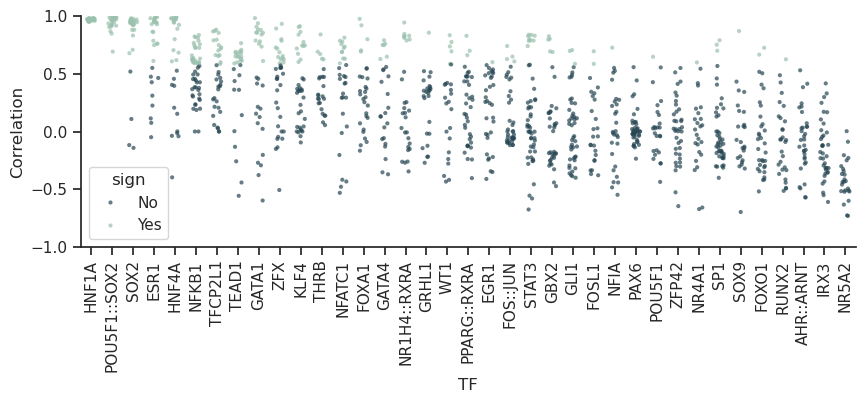

In [4]:
# Filter the dataframe
filtered_df = rna_correlations_df[rna_correlations_df['reasonable'] == 'Yes']
filtered_df = filtered_df[['reporter_id', 'cor_pval', 'cor', 'tf', 'commercial_reporter']].drop_duplicates()

# Add a new column 'sign'
filtered_df['sign'] = ['Yes' if pval > 1 else 'No' for pval in filtered_df['cor_pval']]

# Calculate mean correlation per TF
filtered_df['mean_cor'] = filtered_df.groupby('tf')['cor'].transform('mean')

# Plot the data, combine stripplot and violinplot
plt.figure(figsize=(10, 3))
## Remove grid
sns.set(style='ticks')
## Create stripplot, color matches p-value
sns.stripplot(x='tf', y='cor', data=filtered_df, order=filtered_df.groupby('tf')['mean_cor'].mean().sort_values(ascending=False).index, hue = 'sign', size=3, jitter=0.2, palette=['#264653', '#9AC1AE'], alpha=0.7)
plt.ylim(-1, 1)
plt.xticks(rotation=90)
sns.despine()
## Set axis labels
plt.xlabel('TF')
plt.ylabel('Correlation')
## Save figure to pdf
plt.savefig('/DATA/usr/m.trauernicht/projects/SuRE-TF/figures/Figure_4/rna_correlations_stripplot.pdf', bbox_inches='tight')
plt.show();

Conclusion: For some TFs, the correlations are exceptional. Very interesting: For some TFs, only a fraction of reporters has a good correlation.

---
### TF abundance correlation: SP1 reporters

NameError: name 'add_reg_line' is not defined

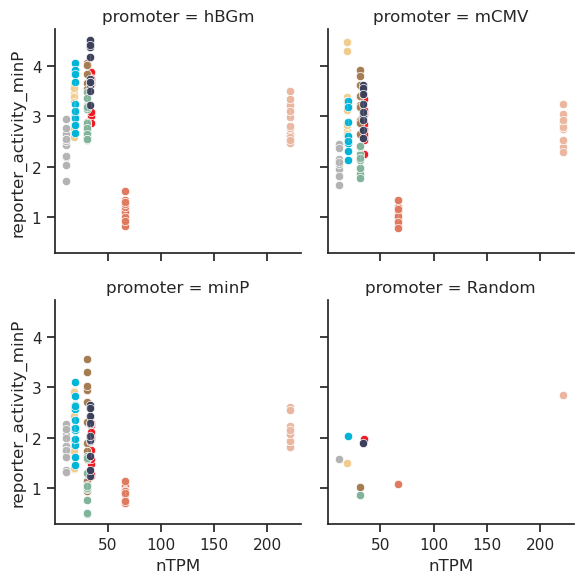

In [5]:
# Filter the dataframe
filtered_df = cDNA_df3[(cDNA_df3['tf'] == "SP1") & (cDNA_df3['commercial_reporter'] == "No")]
filtered_df = filtered_df[['cell', 'reporter_id', 'reporter_activity_minP', 'nTPM', 'promoter', 'cor_pval']].drop_duplicates()

cell_colors = {
    "A549": "#f2cc8f",
    "HCT116": "#ED1C24",
    "HEK293": "#00B4D8",
    "HepG2": "#B3B3B3",
    "K562": "#A67C52",
    "MCF7": "#81B29A",
    "U2OS": "#3D405B",
    "mES": "#EAB69F",
    "NPC": "#E07A5F"
}

# Create a FacetGrid
g = sns.FacetGrid(data=filtered_df, col='promoter', col_wrap=2, hue='cell', palette=cell_colors)

# Map sns.scatterplot to the FacetGrid
g.map(sns.scatterplot, 'nTPM', 'reporter_activity_minP')

g.map(sns.regplot, 'nTPM', 'reporter_activity_minP', color='black', scatter=False)

# Map add_reg_line to the FacetGrid
g.map_dataframe(add_reg_line)

## Add title and axis labels
g.set_axis_labels("nTPM", "Reporter activity (log2)")

# Set the titles to only show the variable value
g.set_titles("{col_name}")

## Save plot to pdf
g.savefig("/DATA/usr/m.trauernicht/projects/SuRE-TF/figures/Figure_4/SP1_TPM_correlation.pdf")
plt.show();

Conclusion: SP1 reporters with a random core promoter display activities that correlate with TF abundance

---
### Example: TF abundance correlation of two GATA4 reporters

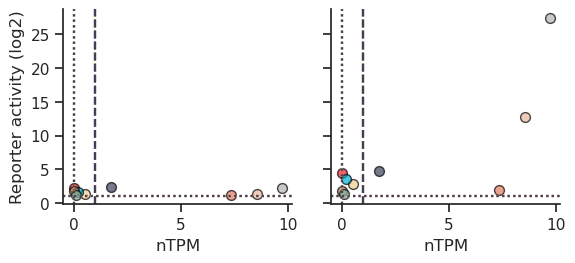

In [6]:
# Filter the dataframe
filtered_df = cDNA_df3[cDNA_df3['reporter_id'].isin(["GATA4_10bp_10bp_minP_3", "GATA4_10bp_10bp_minP_1"])]
filtered_df = filtered_df[['cell', 'reporter_id', 'reporter_activity_minP', 'nTPM']].drop_duplicates()
# Transform the 'reporter_activity_minP' column
filtered_df['reporter_activity_minP'] = 2**filtered_df['reporter_activity_minP']

# Create the plot
sns.set(style='ticks')
g = sns.FacetGrid(filtered_df, col='reporter_id', hue='cell', palette=cell_colors, col_wrap=2, height=3, aspect=1)
g.map(plt.scatter, 'nTPM', 'reporter_activity_minP', s=50, edgecolor='black', alpha=0.7)
g.map(plt.axvline, x=1, linestyle='dashed')
g.map(plt.axvline, x=0, linestyle='dotted')
g.map(plt.axhline, y=1, linestyle='dotted')
g.set_titles("")
g.set_axis_labels("nTPM", "Reporter activity (log2)")
## Save plot to pdf
g.savefig("/DATA/usr/m.trauernicht/projects/SuRE-TF/figures/Figure_4/TFCP2L1_TPM_correlation.pdf")
plt.show();

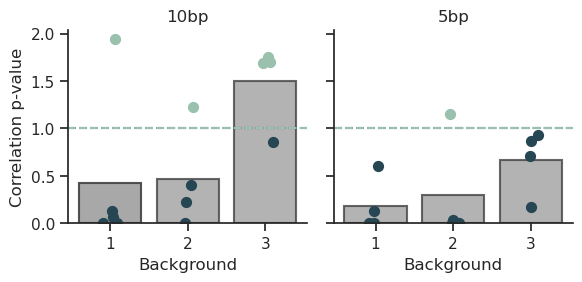

In [7]:
gata4_plot = rna_correlations_df[rna_correlations_df['tf'] == "GATA4"].drop_duplicates(subset=['reporter_id', 'cor_pval', 'spacing', 'background'])
gata4_plot['mean_cor_pval'] = gata4_plot.groupby(['spacing', 'background'])['cor_pval'].transform('mean')

colors_diverse = ["#264653", "#9AC1AE", "#5D987B", "#f2cc8f", "#e76f51"]

# Add a new column 'sign'
gata4_plot['sign'] = ['Yes' if pval > 1 else 'No' for pval in gata4_plot['cor_pval']]

# Create a FacetGrid object
g = sns.FacetGrid(gata4_plot, col='spacing', hue = 'sign', col_wrap=2, height=3, aspect=1, palette=['#264653', '#9AC1AE'])

# Map the plots to the FacetGrid
g.map(plt.axhline, y=1, linestyle='dashed')
g.map(plt.bar, 'background', 'mean_cor_pval', color='grey', edgecolor='black', linewidth=1.5, alpha=0.2)

# Add jitter to the scatter plot
jitter = 0.1  # Adjust this value based on your needs
gata4_plot['background_jitter'] = gata4_plot['background'] + np.random.uniform(-jitter, jitter, size=len(gata4_plot))
g.map(plt.scatter, 'background_jitter', 'cor_pval', s=50)

# Set properties for each subplot
g.set_titles("{col_name}")

# Set axis labels
g.set_axis_labels("Background", "Correlation p-value")

# Save plot to pdf
g.savefig("/DATA/usr/m.trauernicht/projects/SuRE-TF/figures/Figure_4/GATA4_correlation_pval.pdf")

plt.show();

Conclusion: Correlation depends on background sequence.

---
### Example: TF abundance correlation of two TFCP2L1 reporters

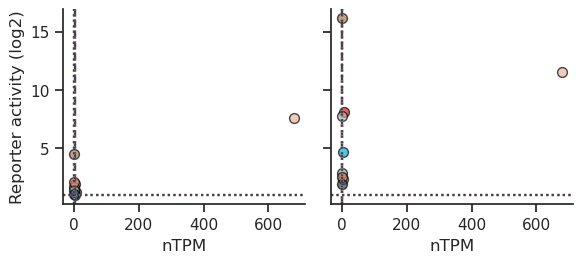

In [8]:
# Filter the dataframe
filtered_df = cDNA_df3[cDNA_df3['reporter_id'].isin(["TFCP2L1_10bp_10bp_minP_1", "TFCP2L1_5bp_10bp_minP_1"])]
filtered_df = filtered_df[['cell', 'reporter_id', 'reporter_activity_minP', 'nTPM']].drop_duplicates()
# Transform the 'reporter_activity_minP' column
filtered_df['reporter_activity_minP'] = 2**filtered_df['reporter_activity_minP']

# Create the plot
sns.set(style='ticks')
g = sns.FacetGrid(filtered_df, col='reporter_id', hue='cell', palette=cell_colors, col_wrap=2, height=3, aspect=1)
g.map(plt.scatter, 'nTPM', 'reporter_activity_minP', s=50, edgecolor='black', alpha=0.7)
g.map(plt.axvline, x=1, linestyle='dashed')
g.map(plt.axvline, x=0, linestyle='dotted')
g.map(plt.axhline, y=1, linestyle='dotted')
g.set_titles("")
g.set_axis_labels("nTPM", "Reporter activity (log2)")
## Save plot to pdf
g.savefig("/DATA/usr/m.trauernicht/projects/SuRE-TF/figures/Figure_4/TFCP2L1_TPM_correlation.pdf")
plt.show();

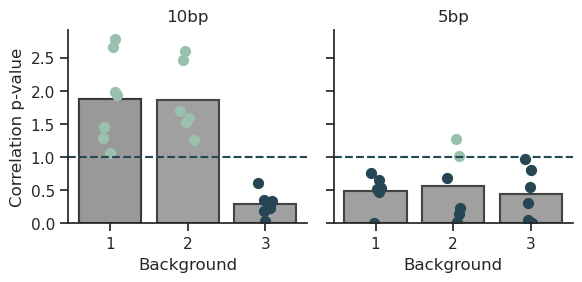

In [9]:
tfcp2l1_plot = rna_correlations_df[rna_correlations_df['tf'] == "TFCP2L1"].drop_duplicates(subset=['reporter_id', 'cor_pval', 'spacing', 'background'])
tfcp2l1_plot['mean_cor_pval'] = tfcp2l1_plot.groupby(['spacing', 'background'])['cor_pval'].transform('mean')

colors_diverse = ["#264653", "#9AC1AE", "#5D987B", "#f2cc8f", "#e76f51"]

# Add a new column 'sign'
tfcp2l1_plot['sign'] = ['Yes' if pval > 1 else 'No' for pval in tfcp2l1_plot['cor_pval']]

# Create a FacetGrid object
g = sns.FacetGrid(tfcp2l1_plot, col='spacing', hue = 'sign', col_wrap=2, height=3, aspect=1, palette=['#9AC1AE', '#264653'])

# Map the plots to the FacetGrid
g.map(plt.axhline, y=1, linestyle='dashed')
g.map(plt.bar, 'background', 'mean_cor_pval', color='grey', edgecolor='black', linewidth=1.5, alpha=0.2)

# Add jitter to the scatter plot
jitter = 0.1  # Adjust this value based on your needs
tfcp2l1_plot['background_jitter'] = tfcp2l1_plot['background'] + np.random.uniform(-jitter, jitter, size=len(tfcp2l1_plot))
g.map(plt.scatter, 'background_jitter', 'cor_pval', s=50)

# Set properties for each subplot
g.set_titles("{col_name}")

# Set axis labels
g.set_axis_labels("Background", "Correlation p-value")

# Save plot to pdf
g.savefig("/DATA/usr/m.trauernicht/projects/SuRE-TF/figures/Figure_4/TFCP2L1_correlation_pval.pdf")

plt.show();

Conclusion: Correlation depends on background sequence.

---
### Example: TF abundance correlation of two GATA1 reporters

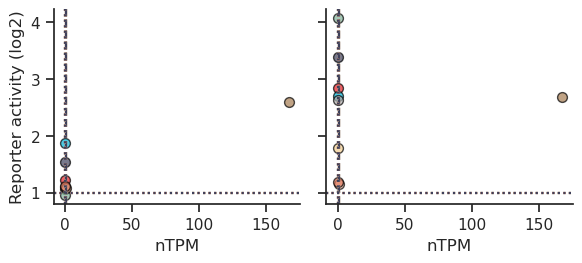

In [10]:
# Filter the dataframe
filtered_df = cDNA_df3[cDNA_df3['reporter_id'].isin(["GATA1_5bp_10bp_minP_3", "GATA1_5bp_21bp_minP_3"])]
filtered_df = filtered_df[['cell', 'reporter_id', 'reporter_activity_minP', 'nTPM']].drop_duplicates()
# Transform the 'reporter_activity_minP' column
filtered_df['reporter_activity_minP'] = 2**filtered_df['reporter_activity_minP']

# Create the plot
sns.set(style='ticks')
g = sns.FacetGrid(filtered_df, col='reporter_id', hue='cell', palette=cell_colors, col_wrap=2, height=3, aspect=1)
g.map(plt.scatter, 'nTPM', 'reporter_activity_minP', s=50, edgecolor='black', alpha=0.7)
g.map(plt.axvline, x=1, linestyle='dashed')
g.map(plt.axvline, x=0, linestyle='dotted')
g.map(plt.axhline, y=1, linestyle='dotted')
g.set_titles("")
g.set_axis_labels("nTPM", "Reporter activity (log2)")
## Save plot to pdf
g.savefig("/DATA/usr/m.trauernicht/projects/SuRE-TF/figures/Figure_4/GATA1_TPM_correlation.pdf")
plt.show();

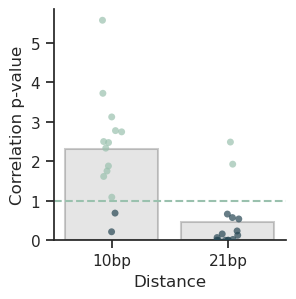

In [11]:
# Filter the dataframe
gata1_plot = rna_correlations_df[rna_correlations_df['tf'] == "GATA1"]
gata1_plot = gata1_plot[['reporter_id', 'cor_pval', 'distance']].drop_duplicates()
gata1_plot['mean_cor_pval'] = gata1_plot.groupby('distance')['cor_pval'].transform('mean')
gata1_plot['sign'] = ['Yes' if pval > 1 else 'No' for pval in gata1_plot['cor_pval']]
colors_diverse = ["#9AC1AE", "#264653"]

# Generate plot
plt.figure(figsize=(3, 3))
plt.axhline(y=1, linestyle='dashed', color = "#9AC1AE")
plt.bar(x=gata1_plot['distance'].unique(), height=gata1_plot.groupby('distance')['mean_cor_pval'].mean(), color='grey', edgecolor='black', linewidth=1.5, alpha=0.2)
sns.stripplot(data = gata1_plot, x=gata1_plot['distance'], y=gata1_plot['cor_pval'], jitter=0.1, hue = 'sign', palette=colors_diverse, size=5, alpha=0.7)
plt.legend().remove()
sns.despine()
## Set axis labels
plt.xlabel('Distance')
plt.ylabel('Correlation p-value')

# Save plot to pdf
g.savefig("/DATA/usr/m.trauernicht/projects/SuRE-TF/figures/Figure_4/GATA1_correlation_pval.pdf")
plt.show();

Conclusion: Correlation depends on distance to core promoter. 

---
### Figure 4: Showcase how reporter activities change upon perturbation
Aim: Demonstrate perturbation responses and differences between reporter designs.

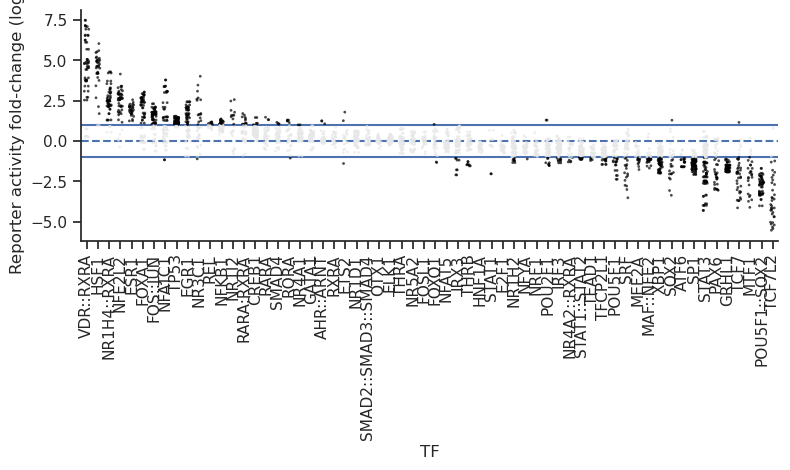

In [31]:
# Combine off_target_activities and on_target_activities dataframes
effect_sizes = pd.concat([off_target_activities[['condition', 'effect_size']].drop_duplicates(),
                          on_target_activities[['condition', 'effect_size']].drop_duplicates()])

# Replace NaN values with 0
effect_sizes['effect_size'] = effect_sizes['effect_size'].fillna(0)

# Rename columns
effect_sizes = effect_sizes.rename(columns={'condition': 'perturbation_condition'})

# Select columns
effect_sizes = effect_sizes[['perturbation_condition', 'effect_size']]


# Filter the dataframe
filtered_df = cDNA_df_confidence2[['tf', 'reporter_id', 'reporter_dif_minP', 'commercial_reporter', 'perturbation_condition']].drop_duplicates()

# Left join with effect_sizes dataframe
filtered_df = filtered_df.merge(effect_sizes, how='left', on='perturbation_condition')

# Replace reporter_dif_minP values based on effect_size
filtered_df['reporter_dif_minP'] = np.where(filtered_df['effect_size'] == 0, -filtered_df['reporter_dif_minP'], filtered_df['reporter_dif_minP'])

# Calculate the number of reporters per tf
filtered_df['n_reporters'] = filtered_df.groupby('tf')['reporter_id'].transform('count')

# Filter out tf with less than 10 reporters
filtered_df = filtered_df[filtered_df['n_reporters'] > 10]

# Calculate the mean of reporter_dif_minP per tf
filtered_df['dif_mean'] = filtered_df.groupby('tf')['reporter_dif_minP'].transform('mean')

# Filter out tf with dif_mean equal to 0
filtered_df = filtered_df[filtered_df['dif_mean'] != 0]

# Remove TFs with only NA values in reporter_dif_minP
filtered_df = filtered_df.dropna(subset=['reporter_dif_minP'])

filtered_df['sign'] = np.where(abs(filtered_df['reporter_dif_minP']) > 1, 1, 0)

# Get the order of 'tf' by the descending 'mean_tf_activity'
order = filtered_df.sort_values('dif_mean', ascending=False)['tf'].unique()

# Create the plot
plt.figure(figsize=(9, 3))
sns.stripplot(data=filtered_df, x='tf', y='reporter_dif_minP', hue='sign', palette={1: 'black', 0: '#E6E7E8'}, order=order, size=2, jitter=0.2, alpha=0.7)
plt.axhline(y=0, linestyle='dashed')
plt.axhline(y=1, linestyle='solid')
plt.axhline(y=-1, linestyle='solid')
plt.xticks(rotation=90)
plt.xlabel('TF')
plt.ylabel('Reporter activity fold-change (log2)')
plt.legend().remove()
sns.despine()
## Save plot to pdf
plt.savefig('/DATA/usr/m.trauernicht/projects/SuRE-TF/figures/Figure_4/perturbation_fold_changes_all.pdf', bbox_inches='tight')
plt.show();

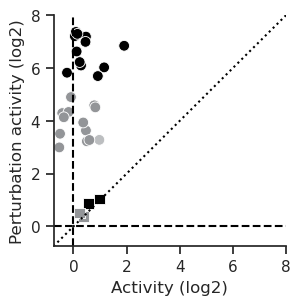

In [44]:
# Filter the dataframe
filtered_df = cDNA_df[(cDNA_df['tf'].str.contains("VDR")) & 
                      (cDNA_df['condition'].isin(["U2OS", "U2OS_Calcitriol"])) & 
                      (cDNA_df['neg_ctrls'] == "No")]

# Select relevant columns and remove duplicates
filtered_df = filtered_df[['reporter_id', 'commercial_reporter', 'condition', 'reporter_activity_minP', 'promoter']].drop_duplicates()

# Spread the dataframe based on 'condition' column
spread_df = filtered_df.pivot(index=['reporter_id', 'commercial_reporter', 'promoter'], columns='condition', values='reporter_activity_minP')

# Create the plot
plt.figure(figsize=(3, 3))
sns.scatterplot(data=spread_df, x=np.log2(spread_df['U2OS']), y=np.log2(spread_df['U2OS_Calcitriol']), hue='promoter', style='commercial_reporter', palette=['black', '#939598', '#BCBEC0', '#E6E7E8'], markers=['o', 's', 'D', 'X'], s=60)
plt.axhline(y=0, linestyle='dashed', color = 'black')
plt.axvline(x=0, linestyle='dashed', color = 'black')
plt.plot([-0.75, 8], [-0.75, 8], linestyle='dotted', color = 'black')
plt.xlim(-0.75, 8)
plt.ylim(-0.75, 8)
plt.xlabel('Activity (log2)')
plt.ylabel('Perturbation activity (log2)')
plt.legend().remove()
sns.despine()
plt.show();
